<a href="https://colab.research.google.com/github/pranscript/neural_jupyter/blob/master/EMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline                                               
%config InlineBackend.figure_format = 'retina'                   

import numpy as np
import torch

In [0]:
import matplotlib.pyplot as plt                                                  
from torchvision import datasets, transforms                       
from torch import nn                                                 
import torch.nn.functional as F                                   
from torch import optim 

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# 'download=true' downloads the dataset, 'train=true' creates dataset from training otherwise from test.
# dataloader provides an batch loading function for dataset. 'batch_size' set no. of samples per batch to load. 'Shuffle=true' shuffles data every epoch.
trainset = datasets.EMNIST('~/.pytorch/EMNIST_data/', split='letters', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.EMNIST('~/.pytorch/EMNIST_data/', split='letters', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [9]:
trainset

Dataset EMNIST
    Number of datapoints: 124800
    Root location: /root/.pytorch/EMNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [10]:
trainloader.batch_size

64

In [0]:
input_size = 784                                                    
hidden_sizes1 = [256, 128]
hidden_sizes2 = [128, 64]
output_size = 27

In [13]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes1[0])),
                      ('relu1', nn.ReLU()),
                      ('drop1', nn.Dropout(p=0.2)),
                      ('fc2', nn.Linear(hidden_sizes1[0], hidden_sizes1[1])),
                      ('relu2', nn.ReLU()),
                      ('drop2', nn.Dropout(p=0.2)),
                      ('fc3', nn.Linear(hidden_sizes2[0], hidden_sizes2[1])),
                      ('relu3', nn.ReLU()),
                      ('drop3', nn.Dropout(p=0.2)),
                      ('output', nn.Linear(hidden_sizes2[1], output_size)),
                      ('logsoftmax', nn.LogSoftmax(dim=1))]))

criterion = nn.NLLLoss()      # negative log loss
optimizer = optim.Adam(model.parameters(), lr=0.003)
print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (drop3): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=64, out_features=27, bias=True)
  (logsoftmax): LogSoftmax()
)


In [14]:
train_losses, test_losses = [], []

epochs = 30
steps = 0

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        #print(f"Training loss: {running_loss/len(trainloader)}")

        test_loss = 0
        accuracy = 0

        with torch.no_grad():
          model.eval()
          for images, labels in testloader:
            images = images.view(images.shape[0], -1)
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 1.172..  Test Loss: 0.639..  Test Accuracy: 0.799
Epoch: 2/30..  Training Loss: 0.866..  Test Loss: 0.564..  Test Accuracy: 0.824
Epoch: 3/30..  Training Loss: 0.806..  Test Loss: 0.511..  Test Accuracy: 0.844
Epoch: 4/30..  Training Loss: 0.772..  Test Loss: 0.510..  Test Accuracy: 0.844
Epoch: 5/30..  Training Loss: 0.750..  Test Loss: 0.532..  Test Accuracy: 0.840
Epoch: 6/30..  Training Loss: 0.734..  Test Loss: 0.494..  Test Accuracy: 0.851
Epoch: 7/30..  Training Loss: 0.723..  Test Loss: 0.470..  Test Accuracy: 0.859
Epoch: 8/30..  Training Loss: 0.710..  Test Loss: 0.469..  Test Accuracy: 0.859
Epoch: 9/30..  Training Loss: 0.708..  Test Loss: 0.474..  Test Accuracy: 0.860
Epoch: 10/30..  Training Loss: 0.699..  Test Loss: 0.473..  Test Accuracy: 0.853
Epoch: 11/30..  Training Loss: 0.689..  Test Loss: 0.455..  Test Accuracy: 0.861
Epoch: 12/30..  Training Loss: 0.684..  Test Loss: 0.475..  Test Accuracy: 0.849
Epoch: 13/30..  Training Loss: 0.676.

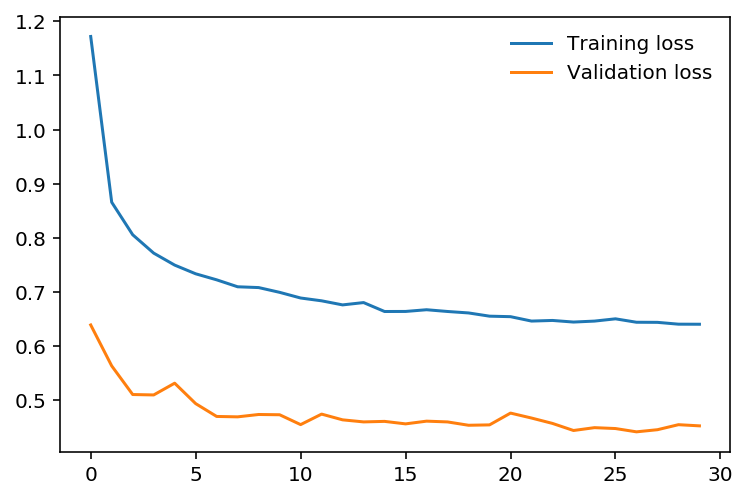

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

AttributeError: ignored

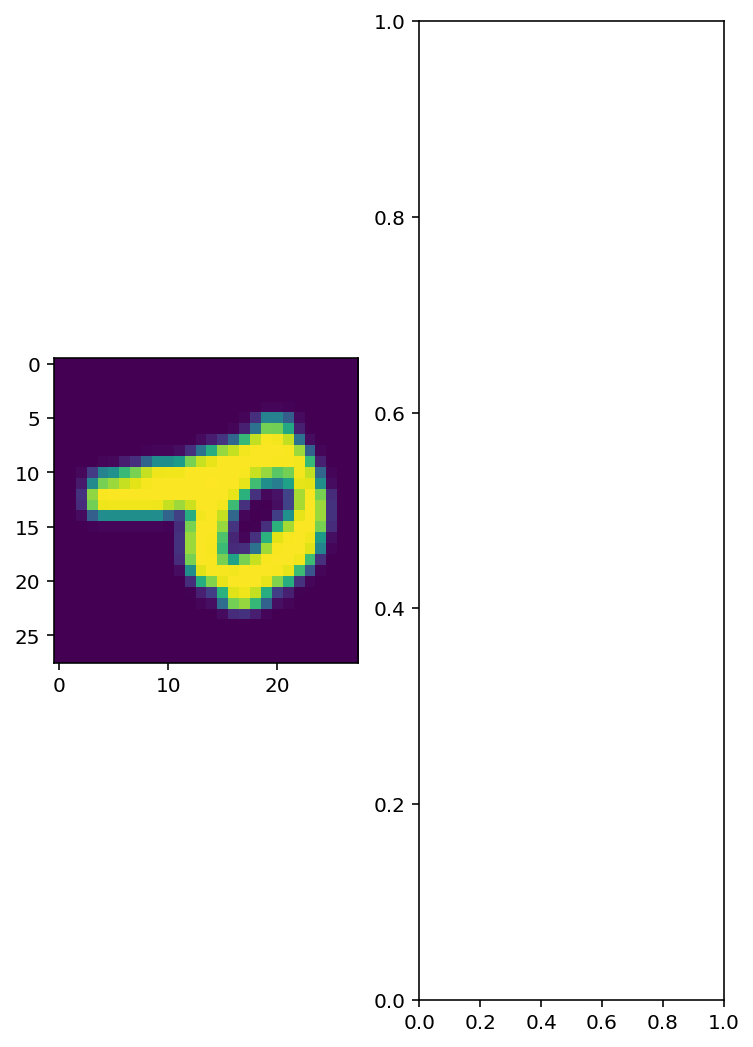

In [69]:
images, labels = next(iter(trainloader))
img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model.forward(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
#print(logps)                
ps = torch.exp(logps)
#print(ps)

img = img.view(1, 28, 28)
ps = ps.data.numpy().squeeze()
#ps
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
#ax1.axis('off')
ax2.barh(np.arange(27), ps)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(27))
ax2.set_yticklabels(['un','A',
                            'B',
                            'C',
                            'D',
                            'E',
                            'F',
                            'G',
                            'H',
                            'I',
                            'J',
                            'K',
                            'L',
                            'M',
                            'N',
                            'O',
                            'P',
                            'Q',
                            'R',
                            'S',
                            'T',
                            'U',
                            'V',
                            'W',
                            'X',
                            'Y',
                            'Z'], size='small');
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()